In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import glob
from IPython.display import Latex
import IPython
import re
from scipy.integrate import solve_ivp


## Pre-Processings

In [2]:
start_date = "2016-01-01"

$$
\frac {\partial Q}{\partial t} = \frac{1}{k} \left ( I(t) - Q(t) \right )
$$

$$
\frac{\partial I}{ \partial t} = \frac{\partial Q}{ \partial t} + k \frac{\partial^2 Q}{ \partial t^2}
$$



In [33]:
d1_name ="Data/VIX_History*"
d1_filename = glob.glob(d1_name)[0]
d1= pd.read_csv(d1_filename)

d1.columns = d1.columns.str.upper()
d1['DATE'] = pd.to_datetime(d1["DATE"])
d1= d1.set_index("DATE")


d1=d1.loc[start_date:]
vix = d1[["CLOSE"]]


In [4]:
d1_week = d1.resample("1W").sum()
d1_week = d1_week[start_date:]

d1_week = d1_week[["CLOSE"]]
d1_week.columns = ["VIX"]

In [5]:
d2_name ="Data/2_Day_Smooth_Metaculus_Users_*"
d2_filename = glob.glob(d2_name)[0]
d2= pd.read_csv(d2_filename)
d2.columns = d2.columns.str.upper()
d2['DATE'] = pd.to_datetime(d2["DATE"])
d2= d2.set_index("DATE")
d2.columns = ["META"]
d2_week = d2.resample("1W").sum()


metaculus = d2.loc[start_date:]
metaculus_week = d2_week.loc[start_date:]


In [6]:
vix0= d1["CLOSE"][0]

## Google Data

In [7]:
partial_name = f'Data/google*'
filename = glob.glob(partial_name)[0]
df_weekly= pd.read_csv(filename)

df_weekly['Week'] = pd.to_datetime(df_weekly["Week"])
df_weekly = df_weekly.set_index("Week")
df_weekly.columns=["Searches"]
df_weekly['Searches']= pd.to_numeric(df_weekly['Searches'])

In [8]:
df_weekly.index.names = ["DATE"]
weekly_users = df_weekly.iloc[:,:1]

df_google = weekly_users


In [9]:
partial_name = f'Data/google_bonds*'
filename = glob.glob(partial_name)[0]
df_weekly= pd.read_csv(filename)

df_weekly['Week'] = pd.to_datetime(df_weekly["Week"])
df_weekly = df_weekly.set_index("Week")
df_weekly.columns=["Searches"]
df_weekly['Searches']= pd.to_numeric(df_weekly['Searches'])
df_weekly.columns=["Bonds"]

In [10]:
df_weekly.index.names = ["DATE"]

df_bonds = df_weekly
weekly_users = df_weekly.iloc[:,:1]

df_google = df_google.merge(weekly_users, on="DATE")

In [11]:
partial_name = f'Data/google_exchange*'
filename = glob.glob(partial_name)[0]
df_weekly= pd.read_csv(filename)

df_weekly['Week'] = pd.to_datetime(df_weekly["Week"])
df_weekly = df_weekly.set_index("Week")
df_weekly.columns=["Searches"]
df_weekly['Searches']= pd.to_numeric(df_weekly['Searches'])
df_weekly.columns=["Exchange Rate"]

In [12]:

df_weekly.index.names = ["DATE"]

df_exchange  = df_weekly

weekly_users = df_weekly.iloc[:,:1]

df_google = df_google.merge(weekly_users, on="DATE")

In [13]:
partial_name = f'Data/google_interest*'
filename = glob.glob(partial_name)[0]
df_weekly= pd.read_csv(filename)

df_weekly['Week'] = pd.to_datetime(df_weekly["Week"])
df_weekly = df_weekly.set_index("Week")
df_weekly.columns=["Searches"]
df_weekly['Searches']= pd.to_numeric(df_weekly['Searches'])
df_weekly.columns=["Interest Rate"]

In [14]:

df_weekly.index.names = ["DATE"]
df_interest=df_weekly

In [15]:
weekly_users = df_weekly.iloc[:,:1]
df_google = df_google.merge(weekly_users, on="DATE")


In [16]:
partial_name = f'Data/google_stock_market.csv'
filename = glob.glob(partial_name)[0]
df_weekly= pd.read_csv(filename)

df_weekly['Week'] = pd.to_datetime(df_weekly["Week"])
df_weekly = df_weekly.set_index("Week")
df_weekly.columns=["Searches"]
df_weekly['Searches']= pd.to_numeric(df_weekly['Searches'])
df_weekly.columns=["Stock Market"]

In [17]:
df_weekly.index.names = ["DATE"]

df_stock_market  = df_weekly

weekly_users = df_weekly.iloc[:,:1]

df_google = df_google.merge(weekly_users, on="DATE")


In [18]:
d3_name ="Data/SPY_History*"
d3_filename = glob.glob(d3_name)[0]
d3= pd.read_csv(d3_filename)
d3['DATE'] = pd.to_datetime(d3["DATE"])
d3 = d3.set_index("DATE")
d3= d3.loc[start_date:]
d3 = d3.resample("1W").sum()
d3=d3.dropna()
d3= d3.rename(columns={"CLOSE": "SPY CLOSE"})

In [19]:
weekly_users = d3['SPY CLOSE']
df_google = df_google.merge(weekly_users, on="DATE")


In [20]:
df_google=df_google.dropna()

In [21]:
df_google

,Searches,Bonds,Exchange Rate,Interest Rate,Stock Market,SPY CLOSE
DATE,,,,,,
2018-01-14,10,21,75,16,13,1376.620025
2018-01-21,6,47,86,27,11,1116.130005
2018-01-28,25,0,84,0,19,1419.039979
2018-02-04,100,53,87,20,52,1405.369996
2018-02-11,23,0,80,0,17,1319.860016
...,...,...,...,...,...,...
2022-12-04,3,0,65,75,11,2013.110017
2022-12-11,11,37,68,24,12,1976.099976
2022-12-18,12,0,58,0,11,1973.220001


## Streamflow Calculations

In [22]:
i = 30
k = 0.5     #k <1
t = 1

$$
I_n = \frac{k}{\Delta t \cdot i} Q_{n+i} + (1 - \frac{k}{\Delta t \cdot i}) Q_n
$$

$$
I(t) = Q(t) + k \frac{\partial Q}{\partial t}
$$

In [23]:
I = k/t*d1["CLOSE"].shift(-i) + (1 - k/t)*d1["CLOSE"]
I

DATE
2016-01-04    21.505
2016-01-05    20.490
2016-01-06    20.560
2016-01-07    22.185
2016-01-08    23.995
               ...  
2023-02-17       NaN
2023-02-20       NaN
2023-02-21       NaN
2023-02-22       NaN
2023-02-23       NaN
Name: CLOSE, Length: 1805, dtype: float64

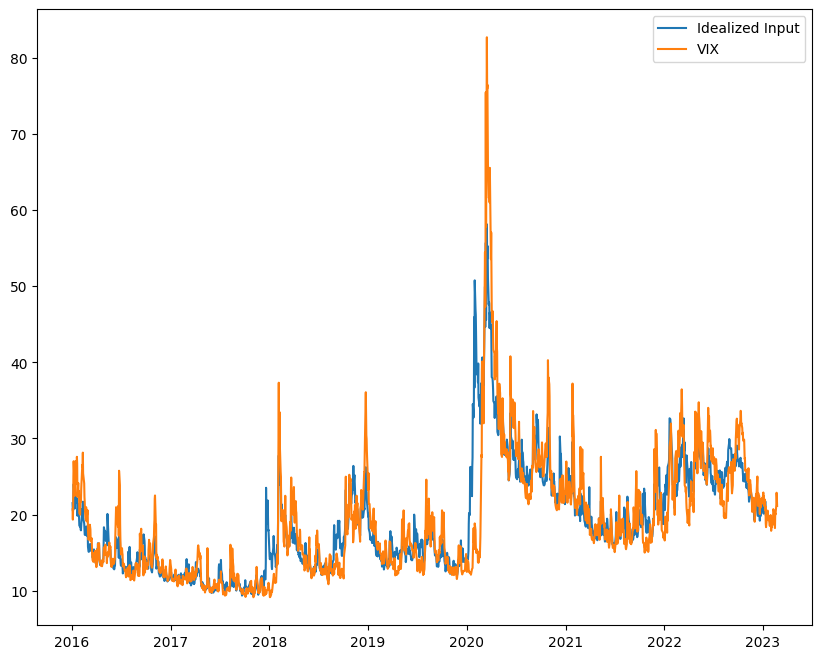

In [24]:
#fig, axs = plt.subplots(2, figsize= (10, 8))
plt.figure(figsize= (10, 8))
plt.plot(I, label = "Idealized Input")
plt.plot(d1["CLOSE"], label = "VIX" )
plt.legend()
plt.show()

In [25]:
I.to_csv('Idealized_Streamflow_{}_{}'.format(i, k))

## VIX --> Idealized Stream --> Alternative Data Prediction via Governing Equation --> VIX Prediction via streamflow

In [26]:
def ideal_streamflow (data, i,k, t= 1):
    I = k/t*d1["CLOSE"].shift(-i) + (1 - k/t)*d1["CLOSE"]
    return(I)

In [27]:
def governing_eq(data, response, lags, power = 5, alphas= 20):
    alphas = np.geomspace(1e-2,1e-1, 20)

    reg_data= response.to_frame()


    for i in range(len(data)):
        for k in lags[i]:
            col_name =  data[i].columns[0]
            df = data[i].shift(k)
            for j in range(power):
                reg_data[str(k) + "_LAG_" + col_name +"_"+str(j+1)] = df[col_name]**(j+1)

    reg_data = reg_data.dropna()

    X = reg_data.iloc[:,1:]
    Y = reg_data.iloc[:,0]
 

    X_norm = X.copy()
    for i in X.columns:    
        X_norm[i] =(X[i] - X[i].mean()) / X[i].std() 

    Y_norm = (Y - Y.mean()) / Y.std() 

    max_score = 0
    opt_alpha = 0
    opt_terms = []
    opt_coef = {}

    for i in alphas:
        lassoreg = Lasso(alpha=i)
        lassoreg.fit(X_norm,Y_norm)
        coefs= lassoreg.coef_
        mask = coefs!=0
        lin_X = X.loc[:, mask]
        if not lin_X.empty:
            linreg = LinearRegression().fit(lin_X, Y)
            score = linreg.score(lin_X,Y)
            if score > max_score:
                opt_alpha = i
                opt_terms = lin_X.columns
                opt_coef = linreg.coef_
                max_score = score
    
    print("Max Score: {}".format(max_score))

    output = ""
    pat = r'.*?_(.*)_.*'

    for i in range(len(opt_terms)):
        lag = opt_terms[i].split('_')[0]
        power = opt_terms[i][-1]
        val = opt_terms[i].split('_')[2]
        
        if i != 0 and opt_coef[i] > 0:
            output += "+ "
        output +=  "{:.2e} \cdot {}_{{Lag: {} }}^{}".format(opt_coef[i], val, lag, power)

    IPython.display.display(Latex(f"""\\begin{{equation*}}
    {output}
    \\end{{equation*}}
    """))

    pred_out = reg_data[opt_terms]
    print(pred_out.shape)
    pred_out = pred_out.dot(opt_coef)

    
    return pred_out

In [37]:
data = [vix, metaculus, df_google]
met_lags = np.arange(10,15)
vix_lags= np.arange(25,30)
google_lags= np.arange(1,5)

lags = [vix_lags, met_lags, google_lags]

In [31]:
d1

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2016-01-04,22.48,23.36,20.67,20.70
2016-01-05,20.75,21.06,19.25,19.34
2016-01-06,21.67,21.86,19.80,20.59
2016-01-07,23.22,25.86,22.40,24.99
2016-01-08,22.96,27.08,22.48,27.01
...,...,...,...,...
2023-02-17,20.94,21.30,19.82,20.02
2023-02-20,21.06,21.28,20.96,21.23
2023-02-21,21.80,23.34,21.80,22.87


In [38]:
pred_I = governing_eq(data, I, lags, power = 5)

ValueError: Found array with 0 sample(s) (shape=(0, 70)) while a minimum of 1 is required by Lasso.

In [ ]:
def stream_fun_parent (I, k):
    def stream_fun (t, q):
        ind= int(t)
        #print(t)
        return (I[ind] - q)*1/k
    return stream_fun
    

In [ ]:
I_ideal= I[~np.isnan(I)]
I_ideal = I_ideal.tolist()

In [ ]:
model_I = pred_I.tolist()
pred_len=20
pred_x = pred_I.index [:-pred_len]
t_eval = np.arange(0, len(model_I)-pred_len)

sol = solve_ivp(stream_fun_parent(model_I, k), [0, len(model_I)-pred_len], [vix0], t_eval=t_eval)

NameError: name 'pred_x' is not defined

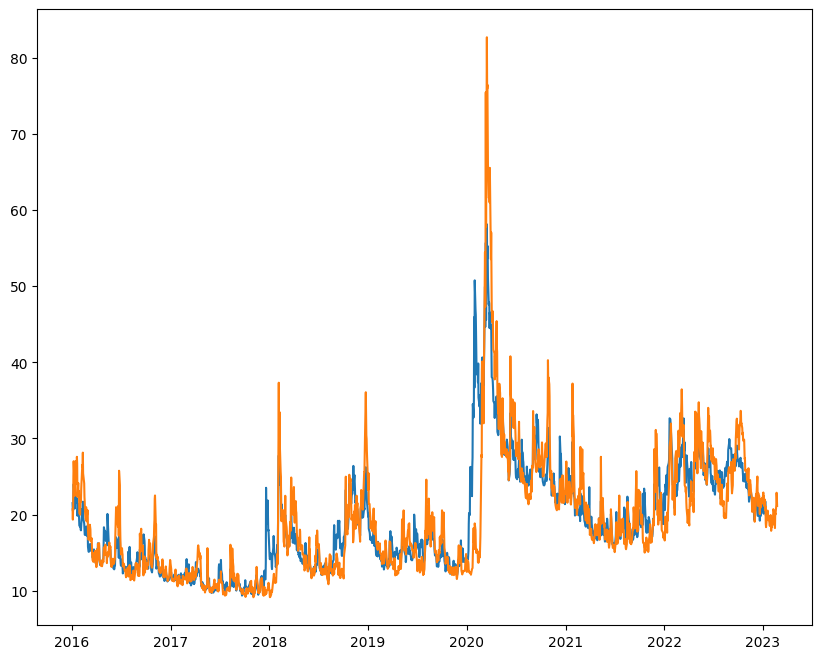

In [39]:
#fig, axs = plt.subplots(2, figsize= (10, 8))
plt.figure(figsize= (10, 8))
plt.plot(I[start_date:], label = "Idealized Input")
plt.plot(d1["CLOSE"][start_date:], label = "VIX" )
plt.plot(pred_x, sol.y[0], label = "Predicted VIX" )
plt.legend()
plt.show()